In [1]:
from nptdms import TdmsFile
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [2]:
from HyperspectralAnalysis import HyperspectralAnalysis 
hyps = HyperspectralAnalysis()

### Read in data files


In [3]:
path_int = '../Mg Analyses/241221/nps_in_glycerol/mg110_glyc_33.tdms'
pathbc = '../Mg Analyses/241221/nps_in_glycerol/mg110_glyc_WC34.tdms'
pathdc = '../Mg Analyses/241221/nps_in_glycerol/mg110_glyc_DC35.tdms'
path_positions = '../Mg Analyses/241221/nps_in_glycerol/mg110_glyc_33/positions.txt'
wavei = 145 # index of starting wavelength 
wavef = 670 # index of end wavelength



# path_int = '../Training Data and Analysis/all_training_data_folders/240920/au77_aft_28.tdms'
# pathbc = '../Training Data and Analysis/all_training_data_folders/240920/au77_WC24.tdms'
# pathdc = '../Training Data and Analysis/all_training_data_folders/240920/au77_DC25.tdms'
# path_positions = '../Training Data and Analysis/all_training_data_folders/240920/au77_aft_28/positions.txt'
# wavei = 205 # index of starting wavelength 
# wavef = 670-235 # index of end wavelength




pixel_params, wave_raw, inten_raw = hyps.read_tdms(tdms_file=TdmsFile.read(path_int), datalen=670)
_, w1, dc_raw =     hyps.read_tdms(tdms_file=TdmsFile.read(pathdc), datalen=1340)
_, w2, bc_raw =    hyps.read_tdms(tdms_file=TdmsFile.read(pathbc),  datalen=1340)

### Process the data


In [4]:
wc_minus_dc = hyps.process_wcdc(dc_raw=dc_raw, 
                         bc_raw=bc_raw,
                         pixel_params=pixel_params)

bk_global, indices = hyps.back_global(I_raw=inten_raw,
                                 percent=0.1)

DFS_backglob = hyps.calc_DFS(inten_raw=inten_raw, 
                             wc_minus_dc=wc_minus_dc, 
                             back=bk_global,
                             )

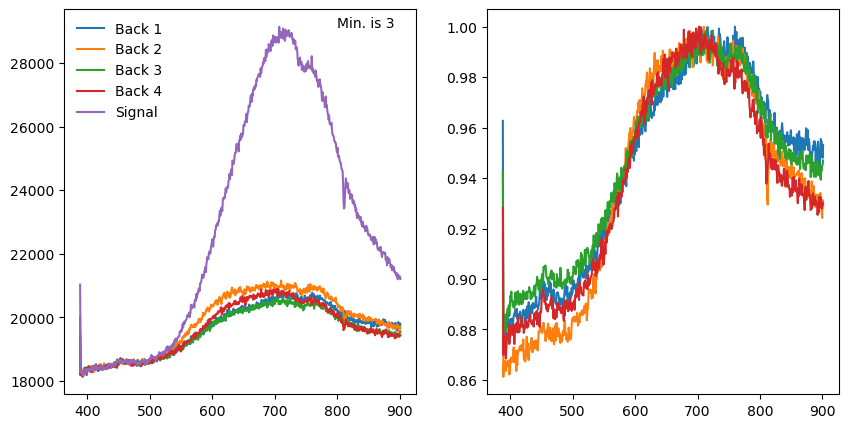

In [9]:
npi = 10 # NP index
positions = np.loadtxt(path_positions)
numPart = len(positions)
xi = int(positions[npi,0])-1
yi = int(positions[npi,1])-1

fig, ax = plt.subplots(1,2, figsize=[10,5])
back_tot, whichmin, back_mingrid = hyps.back_local_grid(specfin=inten_raw, xi=xi, yi=yi, offset=4)


ax[0].plot(wave_raw, back_tot[:,0], label='Back 1')
ax[0].plot(wave_raw, back_tot[:,1], label='Back 2')
ax[0].plot(wave_raw, back_tot[:,2], label='Back 3')
ax[0].plot(wave_raw, back_tot[:,3], label='Back 4')
ax[0].plot(wave_raw, hyps.avg3pixels(inten_raw, xi, yi), label='Signal')
ax[0].text(800, max(hyps.avg3pixels(inten_raw, xi, yi)), str('Min. is ' + str(whichmin+1)))
ax[1].plot(wave_raw, back_tot[:,0] / max(back_tot[:,0]), )
ax[1].plot(wave_raw, back_tot[:,1] / max(back_tot[:,1]),)
ax[1].plot(wave_raw, back_tot[:,2] / max(back_tot[:,2]),)
ax[1].plot(wave_raw, back_tot[:,3] / max(back_tot[:,3]), )



ax[0].legend(frameon=False)

### Plot spectra for all NPs.
Compare global background subtraction and local background subtraction techniques.

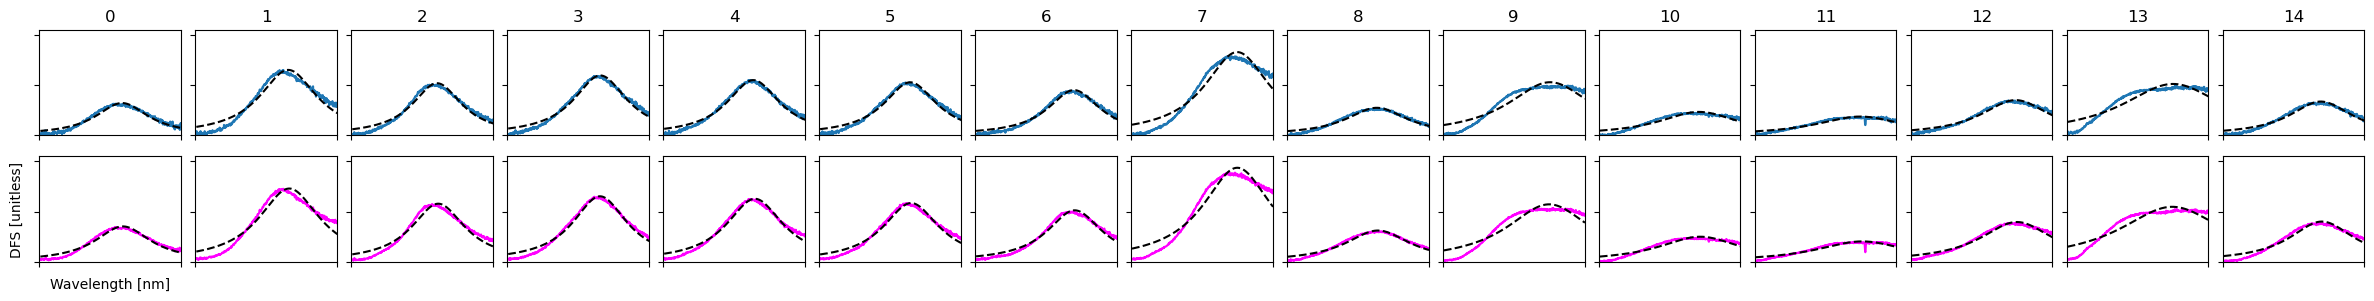

In [10]:
numPlot = numPart

fig, ax = plt.subplots(2,numPlot, figsize=[numPlot*2, 4],sharex=True, sharey=True)

wave = wave_raw[wavei:wavef]

gam_global = np.zeros(numPlot)
eres_global = np.zeros(numPlot)

gam_local = np.zeros(numPlot)
eres_local = np.zeros(numPlot)

DFS_localgrid = hyps.calc_DFS_localgrid(specfin=inten_raw,
                    numPart=numPart,
                    positions=positions,
                    wavei=wavei,
                    wavef=wavef,
                    wc_minus_dc=wc_minus_dc,
                    offset=4)

for npi in range(0,numPlot):
    idx = npi
#     idx = 0
    xi = int(positions[npi,0])-1
    yi = int(positions[npi,1])-1
    
    ax[0,idx].plot(wave, DFS_localgrid[:,npi])
    fit_local, popt_local = hyps.fit_spectrum(wave, DFS_localgrid[:,npi])
    ax[0,idx].plot(wave, fit_local, color='k', linestyle='--', label=int(popt_local[1]))
    gam_local[npi] = popt_local[1]; eres_local[npi] = popt_local[2]
    
    
    
    
    DFS_global = hyps.avg3pixels(M=DFS_backglob, xi=xi, yi=yi)
    ax[1,idx].plot(wave, DFS_global[wavei:wavef], color='magenta', label='Fit Background')
    
    
    
    fit_global, popt_global = hyps.fit_spectrum(wave, DFS_global[wavei:wavef])
    ax[1,idx].plot(wave, fit_global, color='k', linestyle='--')
    gam_global[npi] = popt_global[1]; eres_global[npi] = popt_global[2]

    ax[0, idx].set_title(npi)
    ax[0,idx].set_ylim([0,2.1]);
    ax[1,idx].set_ylim([0,2.1]);

    ax[0,idx].set_xticks([500,900])
    ax[1,idx].set_xticks([500,900])
    ax[1,0].set_xticklabels([500,900])
    ax[0,idx].set_xlim([500,900]);
    ax[1,idx].set_xlim([500,900]);

    ax[0,0].set_xticklabels([])
    
    if idx > 0:
        ax[0,idx].set_xticklabels([])
        ax[1,idx].set_xticklabels([])
        ax[0,idx].set_yticklabels([])
        ax[1,idx].set_yticklabels([])


# ax[0,0].set_xlim([600,780]);
ax[1,0].set_ylim([0,2.1]);
ax[1,1].set_ylim([0,2.1]);

ax[1,0].set_xlabel('Wavelength [nm]')
# ax[1,1].set_xlabel('Wavelength [nm]')

ax[1,0].set_ylabel('DFS [unitless]')
fig.subplots_adjust(wspace=.1, bottom=.3)
# fig.savefig('auNRs_subset_allspectra.png', dpi=600)



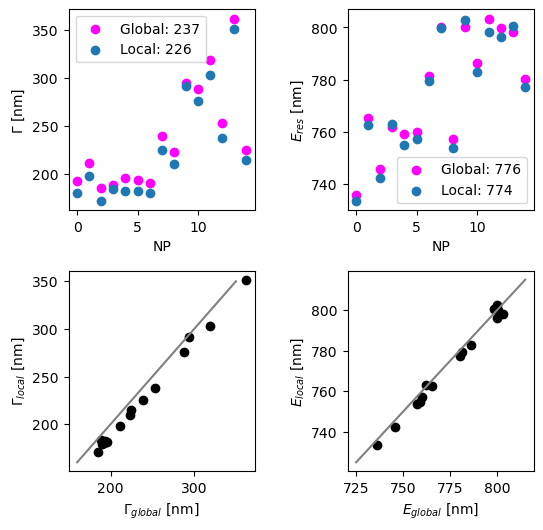

In [7]:
fig, ax = plt.subplots(2,2, figsize=[6,6])


label=str('Global: ')+str(int(np.round(np.mean(gam_global))))
ax[0,0].scatter(np.arange(0, numPlot), gam_global, label=label, color='magenta')
label=str('Local: ')+str(int(np.round(np.mean(gam_local))))
ax[0,0].scatter(np.arange(0,numPlot), gam_local, label=label, color='tab:blue')


ax[1,0].scatter(gam_global, gam_local, color='k')
ax[1,0].plot([160,350], [160,350], color='gray')
ax[1,0].set_xlabel('$\Gamma_{global}$ [nm]')
ax[1,0].set_ylabel('$\Gamma_{local}$ [nm]')


label=str('Global: ')+str(int(np.round(np.mean(eres_global))))
ax[0,1].scatter(np.arange(0,numPlot), eres_global, label=label, color='magenta')
label=str('Local: ')+str(int(np.round(np.mean(eres_local))))
ax[0,1].scatter(np.arange(0,numPlot), eres_local, label=label, color='tab:blue')

ax[1,1].scatter(eres_global, eres_local, color='k')
ax[1,1].plot([725,815], [725,815], color='gray')
ax[1,1].set_xlabel('$E_{global}$ [nm]')
ax[1,1].set_ylabel('$E_{local}$ [nm]')



ax[0,0].set_ylabel('$\Gamma$ [nm]')
ax[0,0].set_xlabel('NP'); ax[0,1].set_xlabel('NP')

ax[0,1].set_ylabel('$E_{res}$ [nm]')

ax[0,0].legend()#frameon=False)
ax[0,1].legend()#frameon=False)

fig.subplots_adjust(wspace=.5, hspace=.3)